# **A/B Test Simulation – 100 Runs**
<hr style="border:1px solid #444;">

#### **Objective**
This notebook simulates A/B tests over 100 iterations to estimate the distribution of lift values and statistical significance across product categories.

### **Notebook Structure**
The notebook is organized into the following sections (top-to-bottom):

1. Simulation Setup
2. Run Simulations
3. Distribution of Observed Lift Percentage
4. Summary Table with 95% CI
5. Business Interpretation
6. Key Takeaways
7. Recommendations


---

### Section 1: Simulation Setup

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

# Set seed for reproducibility
np.random.seed(42)

#Number of simulations
n_simulations = 100

n = 100_000
categories = ['Electronics', 'Clothing', 'Home Goods', 'Beauty', 'Toys']
base_conversion = {
    'Electronics': 0.05,
    'Clothing': 0.08,
    'Home Goods': 0.04,
    'Beauty': 0.07,
    'Toys': 0.06
}


<hr style="border:1px solid #444;">


### Section 2: Run Simulations

In [3]:
results = []
for sim in range(n_simulations):
    group = np.random.choice(['A', 'B'], size=n)
    category = np.random.choice(categories, size=n)
    visits = np.random.randint(50, 300, size=n)

    random_lift = {
        cat: base + np.random.normal(loc=0.01, scale=0.01)
        for cat, base in base_conversion.items()
    }

    # Simulate binary outcomes (1 = success, 0 = failure)
    conversions = []
    for g, c, v in zip(group, category, visits):
        rate = base_conversion[c]
        if g == 'B':
            rate += (random_lift[c] - base_conversion[c])
        conversions.append(np.random.binomial(v, np.clip(rate, 0, 1)))

    df = pd.DataFrame({'Group': group, 'Category': category, 'Visits': visits, 'Conversions': conversions})
    df['Rate'] = df['Conversions'] / df['Visits']
    agg = df.groupby(['Category', 'Group'])[['Visits', 'Conversions']].sum().reset_index()
    agg['Rate'] = agg['Conversions'] / agg['Visits']

    pivot = agg.pivot(index='Category', columns='Group', values='Rate').reset_index()
    pivot['Sim'] = sim + 1
    pivot['Lift_%'] = ((pivot['B'] - pivot['A']) / pivot['A']) * 100
    pivot['StdErr_A'] = np.sqrt(pivot['A'] * (1 - pivot['A']) / agg[agg['Group'] == 'A']['Visits'].values)
    pivot['StdErr_B'] = np.sqrt(pivot['B'] * (1 - pivot['B']) / agg[agg['Group'] == 'B']['Visits'].values)
    pivot['Lift_StdErr'] = np.sqrt((pivot['StdErr_A'] / pivot['A']) ** 2 + (pivot['StdErr_B'] / pivot['B']) ** 2) * np.abs(pivot['Lift_%'])
    pivot['Z'] = pivot['Lift_%'] / (pivot['Lift_StdErr'] + 1e-10)

    # Compute one-tailed p-value from z-score
    pivot['p_value'] = 2 * (1 - norm.cdf(np.abs(pivot['Z'])))
    results.append(pivot)

results_df = pd.concat(results)


<hr style="border:1px solid #444;">


### Section 3: Distribution of Observed Lift Percentage

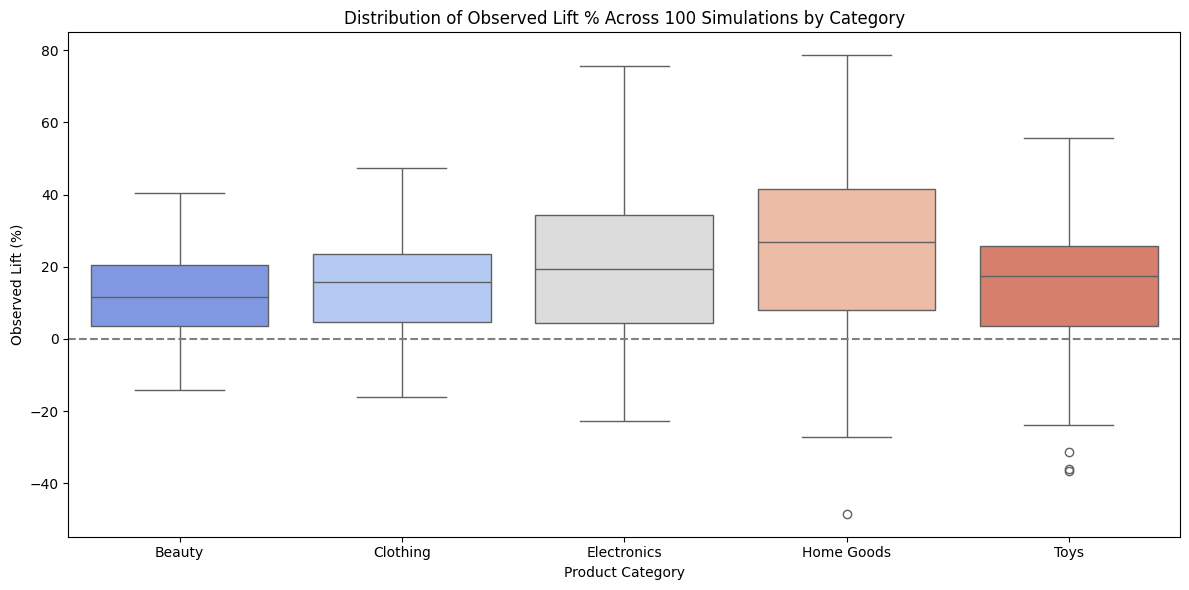

In [10]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=results_df, x='Category', y='Lift_%', hue='Category', palette='coolwarm', dodge=False)
plt.axhline(0, linestyle='--', color='gray')
plt.title("Distribution of Observed Lift % Across 100 Simulations by Category")
plt.ylabel("Observed Lift (%)")
plt.xlabel("Product Category")
plt.tight_layout()
plt.savefig('../../assets/ab_testing/ab_simulation_lift_distribution.png', bbox_inches='tight', dpi=300)
plt.show()


<hr style="border:1px solid #444;">


### Section 4: Summary Table with 95% CI

In [5]:
summary = results_df.groupby('Category').agg({
    'Lift_%': ['mean', 'std']
}).reset_index()
summary.columns = ['Category', 'Mean_Lift', 'StdDev']

significant = results_df[results_df['p_value'] < 0.05].groupby('Category').size()
total = results_df.groupby('Category').size()
summary['Pct_Significant'] = (significant / total * 100).values

summary['95% CI Lower'] = summary['Mean_Lift'] - 1.96 * summary['StdDev']
summary['95% CI Upper'] = summary['Mean_Lift'] + 1.96 * summary['StdDev']

summary.style.format({
    'Mean_Lift': "{:.2f}%",
    'StdDev': "{:.2f}%",
    '95% CI Lower': "{:.2f}%",
    '95% CI Upper': "{:.2f}%",
    'Pct_Significant': "{:.1f}%"
}).set_caption("Simulation Summary: Observed Lift Over 100 Simulations")


,Category,Mean_Lift,StdDev,Pct_Significant,95% CI Lower,95% CI Upper
0,Beauty,12.04%,12.09%,100.0%,-11.66%,35.73%
1,Clothing,14.20%,12.81%,100.0%,-10.90%,39.30%
2,Electronics,19.71%,19.20%,100.0%,-17.92%,57.35%
3,Home Goods,24.50%,24.15%,100.0%,-22.84%,71.84%
4,Toys,14.45%,18.52%,100.0%,-21.84%,50.74%


<hr style="border:1px solid #444;">


### Section 5: Business Interpretation

Simulation results provide directional insight into how often statistically significant differences emerge under controlled assumptions. The spread of observed lift percentages helps gauge the expected variability in real-world campaigns, while the confidence intervals reflect the level of uncertainty.

These insights are essential when planning experiments—especially for setting realistic expectations around required sample sizes and effect detectability.


<hr style="border:1px solid #444;">



### Section 6: Key Takeaways

- **Observed lift distributions** varied across categories, with some consistently producing more detectable effects
- **Statistical noise** can obscure true differences, especially in small lift scenarios or imbalanced samples
- **Confidence intervals** give a reliable summary of expected performance variability and should be communicated clearly to business stakeholders

<hr style="border:1px solid #444;">



### Section 7: Recommendations

- **Set thresholds** for minimum detectable lift and sample size prior to test launch
- **Visualize and simulate** expected power across multiple scenarios before executing large-scale tests
- **Use simulation frameworks** to stress-test assumptions (e.g., variance, imbalance, segment response) before committing real users to experiments



<hr style="border:1px solid #444;">
